# Overview and integration plots

## Content

1. Load modules
2. Import data
3. Compare STITCH and experimental data

## 1. Load modules

In [1]:
import os
import glob
import json
import re

import pandas as pd
import numpy as np
import math
import random 
from collections import Counter
from datetime import date
from datetime import datetime, timedelta
import itertools
from operator import itemgetter

import matplotlib.pyplot as plt
from matplotlib.cm import cool
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set(color_codes=True)
import plotly.express as px

from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

import fastcluster
from scipy import stats
from scipy.stats import kruskal
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import DBSCAN
from scipy.spatial import distance

import hdbscan
import umap

from statsmodels.stats.multitest import multipletests

C:\Users\clanc\anaconda3\lib\site-packages\umap\spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [2]:
# define date for saving figures
today = date.today().strftime("%Y-%m-%d") # for saving files
# set number of columns to show when display is called
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

## 2. Import Data

In [3]:
# Set wd
os.chdir('/Users/clanc/OneDrive/Masterarbeit/analysis')

In [4]:
# Load info tables
screen_info = pd.read_csv('curated_input/screen_info.txt', \
                                   sep = ';', header = 0, index_col = 0)

strain_info = pd.read_csv('curated_input/strain_info.txt', \
                                   sep = ';', header = 0, index_col = 0)

strain_list = json.loads(open("curated_input/strain_list_untar.json").\
                                  read())

condition_list = json.loads(open("curated_input/drug_inkl_contr_list.json").\
                                  read())

In [150]:
# all Dvs No FCs
FC_across_cond_paths = glob.glob(\
    'intermed_results/06_FC_claculation/data/DvsNoD/*.FC_vals.*.feather')

FC_across_cond_perS = [pd.read_feather(file) for file in FC_across_cond_paths]

FC_across_cond_perS = [df.set_index('Compound') for df in FC_across_cond_perS]

del(FC_across_cond_paths)

In [5]:
# Load enrich results (experimental)

DvsNoD_path_enrich_BHPval = pd.read_csv('intermed_results/17_path_enrichment/DvsNoD_path_enrich_BHPval.csv',\
                                    sep = ',', header=0, index_col = 0)
DvsNoD_path_enrich_keggID = pd.read_csv('intermed_results/17_path_enrichment/DvsNoD_path_enrich_keggID.csv',\
                                    sep = ',', header=0, index_col = 0)

In [6]:
stitch_res_all_paths = pd.read_csv('intermed_results/18_stitch/stitch_res_all_paths.csv', sep = ';', index_col = 0)

In [7]:
stitch_res_all_pVals = pd.read_csv('intermed_results/18_stitch/stitch_res_all_pVals.csv', sep = ';', index_col = 0)

In [8]:
contin_tabs = pd.read_csv('intermed_results/18_stitch/contin_tabs.csv', sep = ';', index_col = 0)

Pathway annotation

In [273]:
path_annot_ref_path = '../data_sources/ref_tables/KEGG_Pathway_names.tsv'
path_annot_ref_table = pd.read_csv(path_annot_ref_path, header = None, sep = '\t')
path_annot_ref_table.columns = ['path_id', 'path_name']

## 3. Compare STITCH and experimental data

In [84]:
# Go through STITCH pathways and check for match mit experimental data
stitch_strains = stitch_res_all_paths.index
stitch_drugs = stitch_res_all_paths.columns


In [97]:
# result table

stitch_metabo_match_df = pd.DataFrame(index=stitch_strains, columns=stitch_drugs)


In [98]:
for stitch_s in stitch_strains:
    for stitch_d in stitch_drugs:
        
        stitch_paths = stitch_res_all_paths.loc[stitch_s, stitch_d]
        experiment_paths = DvsNoD_path_enrich_keggID.loc[stitch_s, stitch_d]
        
        if not(pd.isnull(stitch_paths)):
            stitch_paths_split = stitch_paths.split(',')
        else:
            stitch_paths_split = []
        
        if not(pd.isnull(experiment_paths)):
            
            path_hits=[]

            for path in stitch_paths_split:
                if path in experiment_paths:
                    path_hits.append(path)
            
            if len(path_hits)>0:
                stitch_metabo_match_df.loc[stitch_s,stitch_d]= ','.join(str(e) for e in path_hits)

    

## Get drug impact similarity via shared affected pathways

In [255]:
# Metabolomics data
drug_drug_dist_res = pd.DataFrame(0, index=condition_list, columns = condition_list)

In [256]:
def jaccard_sim(l1, l2):
    intersec = len(list(set(l1).intersection(l2)))
    union = (len(l1) + len(l2)) - intersec
    return float(intersec) / union

In [257]:
d_i = DvsNoD_path_enrich_keggID.columns[0]

In [258]:
d_j = DvsNoD_path_enrich_keggID.columns[1]

In [259]:
for d_i in condition_list:
    for d_j in condition_list:

        # get for each drug set of pathways and compare with others
        path_list_i = DvsNoD_path_enrich_keggID[d_i].values
        path_list_i = list(path_list_i[pd.notnull(path_list_i)])
        path_list_i = [s.split(',') for s in path_list_i]
        path_list_i = [item for sublist in path_list_i for item in sublist]
        path_set_i = list(set(path_list_i))

        # get for each drug set of pathways and compare with others
        path_list_j = DvsNoD_path_enrich_keggID[d_j].values
        path_list_j = list(path_list_j[pd.notnull(path_list_j)])
        path_list_j = [s.split(',') for s in path_list_j]
        path_list_j = [item for sublist in path_list_j for item in sublist]
        path_set_j = list(set(path_list_j))
        
        if (len(path_list_i)>3 and len(path_list_j)>3):
            drug_drug_dist_res.loc[d_i, d_j] = jaccard_sim(path_set_i, path_set_j)

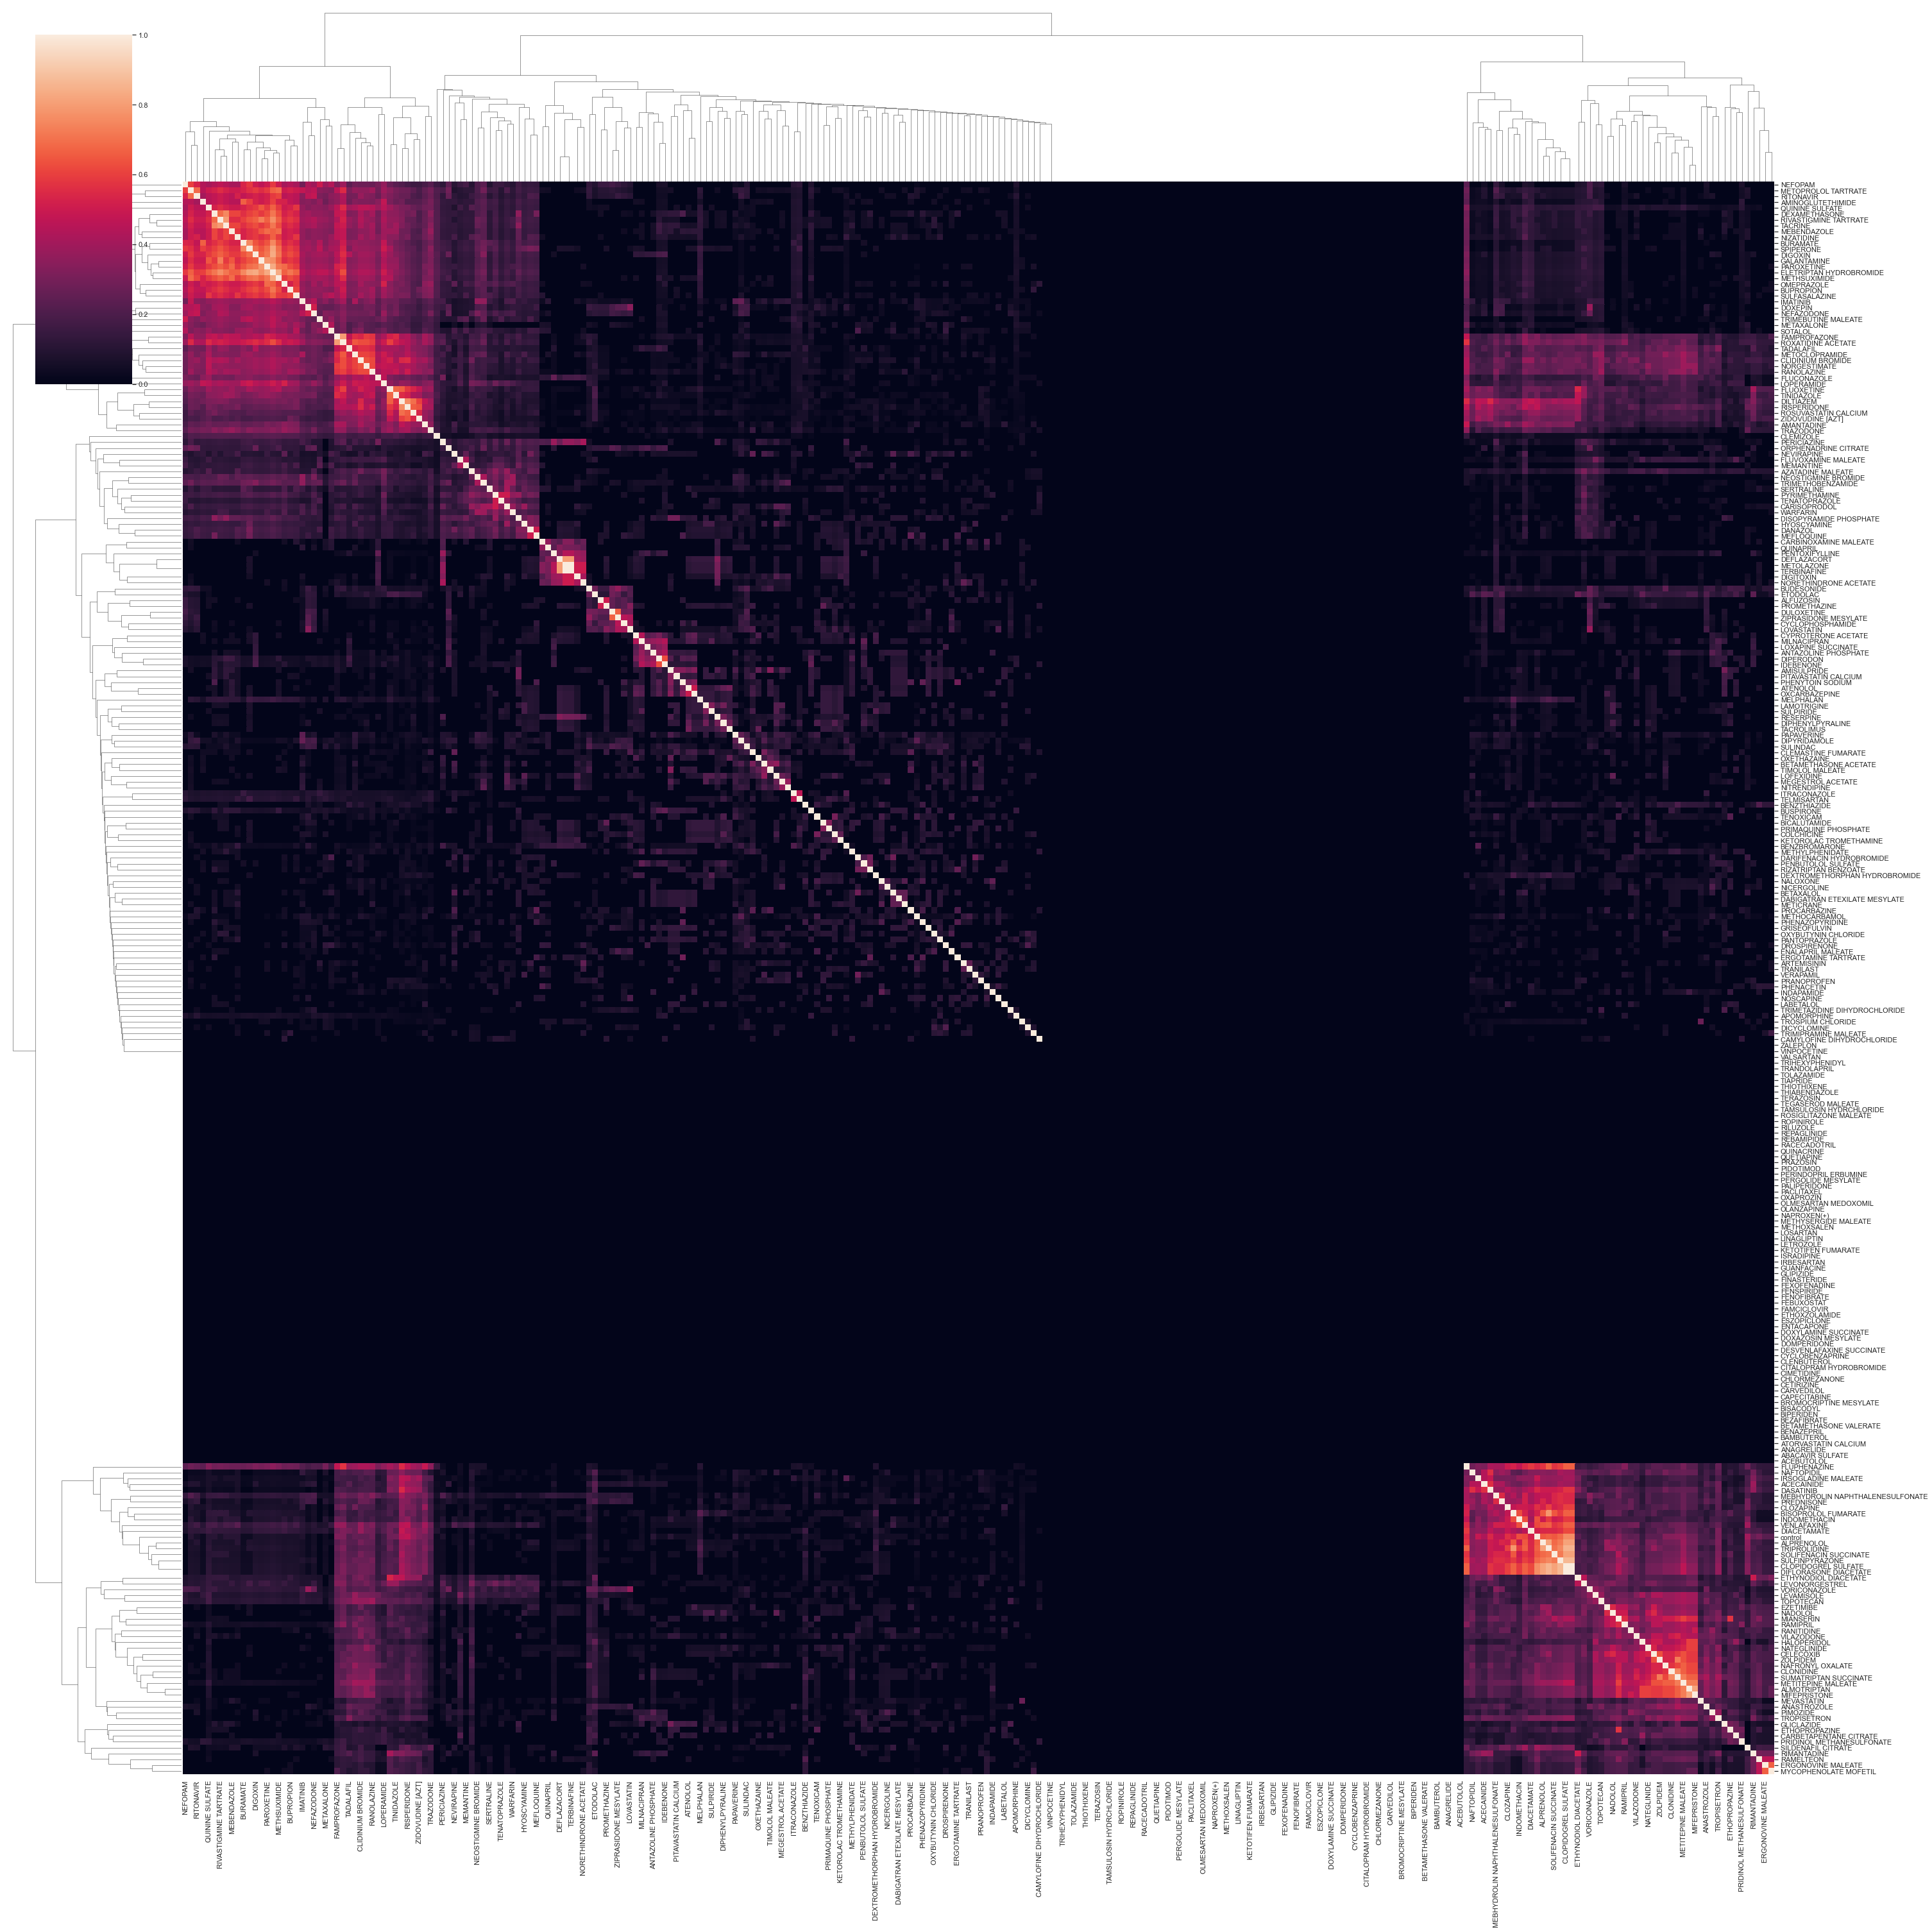

In [262]:

sns.clustermap(drug_drug_dist_res, figsize=(42, 42), yticklabels=True, dendrogram_ratio=0.1) #, metric='precomputed')

In [70]:
experiment_paths = DvsNoD_path_enrich_keggID.loc[stitch_s, stitch_d]

In [68]:
path_hits=[]

for path in stitch_paths_split:
    if path in experiment_paths:
        path_hits.append(path)
        
        
stitch_metabo_match_df.loc[stitch_s,stitch_d]= ','.join(str(e) for e in path_hits)
        

['map05340', 'map02010', 'map01100']

## Get pathways affected by most drug-strain pairs

In [ ]:
DvsNoD_path_enrich_keggID

In [264]:
all_paths = DvsNoD_path_enrich_keggID.values
all_paths = list(all_paths[pd.notnull(all_paths)])
all_paths = [s.split(',') for s in all_paths]
all_paths = [item for sublist in all_paths for item in sublist]


In [271]:
path_count_df = pd.DataFrame({'pathway':list(Counter(all_paths).keys()), 'count':list(Counter(all_paths).values())})

In [283]:
path_count_df['path_name'] = [path_annot_ref_table.loc[path_annot_ref_table['path_id']==path, 'path_name'].values[0] for\
                              path in path_count_df.pathway]

In [369]:
top_paths_sorted = path_count_df.sort_values(by='count', ascending=False)[:30]

In [370]:
top_paths_sorted = top_paths_sorted.sort_values(by='count', ascending=True)

Get values from STITCH

In [312]:
all_stitch_paths = stitch_res_all_paths.values
all_stitch_paths = list(all_stitch_paths[pd.notnull(all_stitch_paths)])
all_stitch_paths = [s.split(',') for s in all_stitch_paths]

In [314]:
all_stitch_paths_set = [list(set(paths)) for paths in all_stitch_paths]

In [316]:
all_stich_paths = [item for sublist in all_stitch_paths_set for item in sublist]

In [317]:
stich_path_count_df = pd.DataFrame({'pathway':list(Counter(all_stich_paths).keys()),\
                                    'count':list(Counter(all_stich_paths).values())})

In [320]:
path_annot_ref_table['stripped_id'] = [s.split(':')[1] for s in path_annot_ref_table['path_id']]

In [329]:
path_name_list = []

for path in stich_path_count_df['pathway']:
    if path in list(path_annot_ref_table['stripped_id']):
        name = path_annot_ref_table.loc[path_annot_ref_table['stripped_id']==path, 'path_name'].values[0]
        path_name_list.append(name)
    else:
        path_name_list.append(np.nan)
    

In [331]:
stich_path_count_df['path_name'] = path_name_list

In [365]:
top_stitch_paths_sorted = stich_path_count_df.sort_values(by='count', ascending=False)[:30]

In [366]:
top_stitch_paths_sorted = top_stitch_paths_sorted.sort_values(by='count', ascending=True)

In [367]:
top_stitch_paths_sorted = top_stitch_paths_sorted.replace(np.nan, 'Biosynthesis of antibiotics')

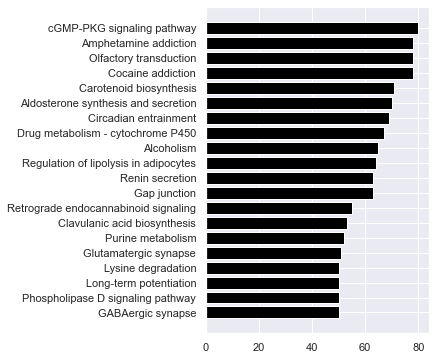

In [363]:
plt.figure(figsize=(4,6))

plt.barh(top_paths_sorted['path_name'], top_paths_sorted['count'], color = 'black')

plt.savefig('intermed_results/21_overview_integration/top_metabolomics_paths.svg', bbox_inches ='tight')

plt.show()

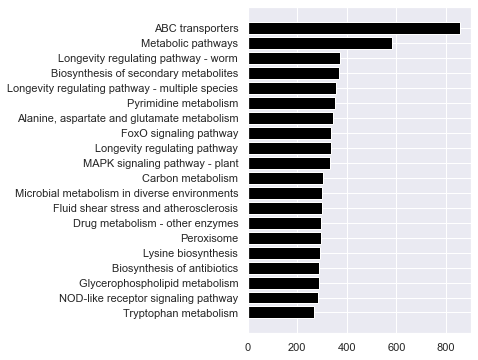

In [364]:
plt.figure(figsize=(4,6))

plt.barh(top_stitch_paths_sorted['path_name'], top_stitch_paths_sorted['count'], color='black')

plt.savefig('intermed_results/21_overview_integration/top_stitch_paths.svg',bbox_inches ='tight')

plt.show()

## Check  matching pathways

In [104]:
DvsNoD_res_paths = glob.glob(\
    'intermed_results/16_DvsNoD_analysis/data/res_BH0.05/*BH0.1_FC0.5_*.csv')

DvsNoD_result_list = [pd.read_csv(filename, header = 0, index_col = 0, sep = ';') for filename in DvsNoD_res_paths]



C:\Users\clanc\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (273,274,275,276) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\clanc\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (275,276) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [107]:
Pval_across_cond_paths = glob.glob(\
    'intermed_results/06_FC_claculation/data/DvsNoD/*.P_vals.*.feather')

Pval_across_cond_perS = [pd.read_feather(file) for file in Pval_across_cond_paths]

Pval_across_cond_perS = [df.set_index('Compound') for df in Pval_across_cond_perS]

del(Pval_across_cond_paths)

Check example:

In [372]:
strain_list.index('S035')

27

In [373]:
filtered_FC_table_noNA

control  ABACAVIR SULFATE  ACEBUTOLOL  ACECAINIDE  \
Compound                                                                
99.1043@3.968           NaN               NaN         NaN         NaN   
99.9817@0.4775517       NaN               NaN    0.543038    1.628109   
101.0059@0.27475        NaN               NaN         NaN         NaN   
101.0463@0.5001363      NaN               NaN         NaN         NaN   
102.0357@1.8591819      NaN               NaN         NaN         NaN   
...                     ...               ...         ...         ...   
971.4953@2.0067666      NaN               NaN         NaN         NaN   
978.08@0.42662162       NaN               NaN         NaN         NaN   
987.5199@3.1003332      NaN               NaN         NaN         NaN   
988.4862@3.007          NaN               NaN         NaN         NaN   
996.5039@2.1365         NaN               NaN         NaN         NaN   

                    ALFUZOSIN  ALMOTRIPTAN  ALPRENOLOL  AMANTADINE  \
Compound                                                             
99.1043@3.968             NaN          NaN         NaN         NaN   
99.9817@0.4775517         NaN          NaN         NaN         NaN   
101.0059@0.27475          NaN          NaN         NaN         NaN   
101.0463@0.5001363        NaN          NaN         NaN         NaN   
102.0357@1.8591819        NaN          NaN         NaN         NaN   
...                       ...          ...         ...         ...   
971.4953@2.0067666        NaN          NaN    0.555434         NaN   
978.08@0.42662162         NaN          NaN         NaN         NaN   
987.5199@3.1003332        NaN          NaN         NaN         NaN   
988.4862@3.007            NaN          NaN         NaN         NaN   
996.5039@2.1365           NaN          NaN         NaN         NaN   

                    AMINOGLUTETHIMIDE  AMISULPRIDE  ANAGRELIDE  ANASTROZOLE  \
Compound                                                                      
99.1043@3.968                     NaN          NaN         NaN          NaN   
99.9817@0.4775517                 NaN          NaN         NaN          NaN   
101.0059@0.27475                  NaN          NaN         NaN          NaN   
101.0463@0.5001363                NaN          NaN         NaN     0.695313   
102.0357@1.8591819                NaN          NaN         NaN          NaN   
...                               ...          ...         ...          ...   
971.4953@2.0067666                NaN          NaN         NaN          NaN   
978.08@0.42662162                 NaN          NaN         NaN          NaN   
987.5199@3.1003332                NaN          NaN         NaN          NaN   
988.4862@3.007                    NaN          NaN         NaN          NaN   
996.5039@2.1365                   NaN          NaN         NaN          NaN   

                    ANTAZOLINE PHOSPHATE  APOMORPHINE  ARTEMISININ  ATENOLOL  \
Compound                                                                       
99.1043@3.968                        NaN          NaN          NaN       NaN   
99.9817@0.4775517                    NaN          NaN     0.535947  0.537028   
101.0059@0.27475                     NaN          NaN          NaN       NaN   
101.0463@0.5001363                   NaN          NaN          NaN       NaN   
102.0357@1.8591819                   NaN          NaN          NaN       NaN   
...                                  ...          ...          ...       ...   
971.4953@2.0067666                   NaN          NaN          NaN       NaN   
978.08@0.42662162                    NaN          NaN          NaN       NaN   
987.5199@3.1003332                   NaN          NaN          NaN       NaN   
988.4862@3.007                       NaN          NaN          NaN       NaN   
996.5039@2.1365                      NaN          NaN          NaN       NaN   

                    ATORVASTATIN CALCIUM  AZATADINE MALEATE  BAMBUTEROL  \
Compound       

In [405]:
strain_idx = strain_list.index('S035')
filtered_FC_table_noNA = DvsNoD_result_list[strain_idx]

P_val_table = Pval_across_cond_perS[strain_idx]

In [406]:
drug_idx = list(filtered_FC_table_noNA.columns).index('ARTEMISININ')

In [407]:
FC_vals_exDrug = filtered_FC_table_noNA.iloc[:, drug_idx]
Pvals_exDrug = P_val_table.loc[filtered_FC_table_noNA.index, filtered_FC_table_noNA.columns[drug_idx]]

4.700359971828111 4-Vinylcyclohexene; 4-Vinyl-1-cyclohexene
2.5041502432285814 Cumene; Isopropylbenzene,Mesitylene; 1,3,5-Trimethylbenzene,1,2,3-Trimethylbenzene; Hemimellitene,3-Ethyltoluene; 1-Methyl-3-ethylbenzene,1,2,4-Trimethylbenzene; Pseudocumene,2-Ethyltoluene; o-Methylethylbenzene; 1-Ethyl-2-methylbenzene
1.5577030581203029 p-Cymene,sec-Butylbenzene; (1-Methylpropyl)benzene; 2-Phenylbutane,1,2,4,5-Tetramethylbenzene; Durene,1,4-Diethylbenzene; p-Diethylbenzene,n-Butylbenzene,p-Cymene
1.842519768760227 4-Propylphenol
5.213058838300117 4-Propylphenol
1.9749381350196098 4-Isopropylbenzaldehyde; p-Cumic aldehyde; Cuminaldehyde,Anethole; t-Anethole; trans-Anethole,Estragole; 1-Methoxy-4-(2-propenyl)benzene; Methylchavicol,5,6,7,8-Tetrahydro-2-naphthol,trans-Lachnophyllol,Cuminaldehyde
4.44459096373476 Ectocarpen
1.9531370409603848 (-)-Carvone; (4R)-Carvone,(+)-Sabinone,Piperitenone,Isopiperitenone,(-)-Isopiperitenone; (-)-(4R)-Isopiperitenone,Perillyl aldehyde; Perillaldehyde,p-Cum

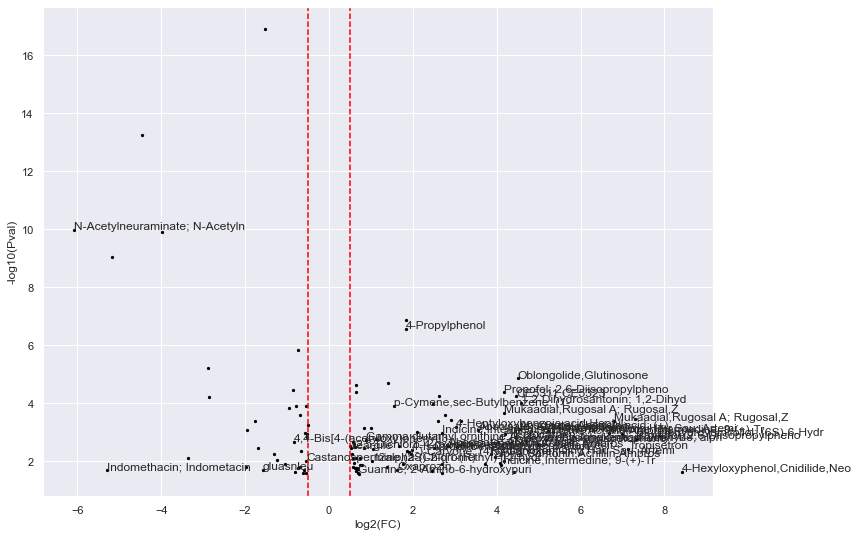

In [409]:
plt.figure(figsize=(12,9))

plt.scatter(np.log2(FC_vals_exDrug), -np.log10(Pvals_exDrug), s = 5, color = 'black')

plt.axvline(x=0.5, linestyle='--', color='red')
plt.axvline(x=-0.5, linestyle='--', color='red')

for x,y,l in zip(np.log2(FC_vals_exDrug), -np.log10(Pvals_exDrug), filtered_FC_table_noNA['comp_names']):
    if all([pd.notnull(x), pd.notnull(y), pd.notnull(l)]):
        plt.text(x,y,l[:30])
        print(x, l)
#plt.axhline(y=5, linestyle='--', color='red')


plt.xlabel('log2(FC)')
plt.ylabel('-log10(Pval)')


plt.show()


In [120]:
strain_list.index('S023')

16

In [133]:
filtered_FC_table_noNA

control  ABACAVIR SULFATE  ACEBUTOLOL  ACECAINIDE  \
Compound                                                                
99.1043@3.968           NaN               NaN         NaN         NaN   
99.9817@0.4775517       NaN               NaN    0.543038    1.628109   
101.0059@0.27475        NaN               NaN         NaN         NaN   
101.0463@0.5001363      NaN               NaN         NaN         NaN   
102.0357@1.8591819      NaN               NaN         NaN         NaN   
...                     ...               ...         ...         ...   
971.4953@2.0067666      NaN               NaN         NaN         NaN   
978.08@0.42662162       NaN               NaN         NaN         NaN   
987.5199@3.1003332      NaN               NaN         NaN         NaN   
988.4862@3.007          NaN               NaN         NaN         NaN   
996.5039@2.1365         NaN               NaN         NaN         NaN   

                    ALFUZOSIN  ALMOTRIPTAN  ALPRENOLOL  AMANTADINE  \
Compound                                                             
99.1043@3.968             NaN          NaN         NaN         NaN   
99.9817@0.4775517         NaN          NaN         NaN         NaN   
101.0059@0.27475          NaN          NaN         NaN         NaN   
101.0463@0.5001363        NaN          NaN         NaN         NaN   
102.0357@1.8591819        NaN          NaN         NaN         NaN   
...                       ...          ...         ...         ...   
971.4953@2.0067666        NaN          NaN    0.555434         NaN   
978.08@0.42662162         NaN          NaN         NaN         NaN   
987.5199@3.1003332        NaN          NaN         NaN         NaN   
988.4862@3.007            NaN          NaN         NaN         NaN   
996.5039@2.1365           NaN          NaN         NaN         NaN   

                    AMINOGLUTETHIMIDE  AMISULPRIDE  ANAGRELIDE  ANASTROZOLE  \
Compound                                                                      
99.1043@3.968                     NaN          NaN         NaN          NaN   
99.9817@0.4775517                 NaN          NaN         NaN          NaN   
101.0059@0.27475                  NaN          NaN         NaN          NaN   
101.0463@0.5001363                NaN          NaN         NaN     0.695313   
102.0357@1.8591819                NaN          NaN         NaN          NaN   
...                               ...          ...         ...          ...   
971.4953@2.0067666                NaN          NaN         NaN          NaN   
978.08@0.42662162                 NaN          NaN         NaN          NaN   
987.5199@3.1003332                NaN          NaN         NaN          NaN   
988.4862@3.007                    NaN          NaN         NaN          NaN   
996.5039@2.1365                   NaN          NaN         NaN          NaN   

                    ANTAZOLINE PHOSPHATE  APOMORPHINE  ARTEMISININ  ATENOLOL  \
Compound                                                                       
99.1043@3.968                        NaN          NaN          NaN       NaN   
99.9817@0.4775517                    NaN          NaN     0.535947  0.537028   
101.0059@0.27475                     NaN          NaN          NaN       NaN   
101.0463@0.5001363                   NaN          NaN          NaN       NaN   
102.0357@1.8591819                   NaN          NaN          NaN       NaN   
...                                  ...          ...          ...       ...   
971.4953@2.0067666                   NaN          NaN          NaN       NaN   
978.08@0.42662162                    NaN          NaN          NaN       NaN   
987.5199@3.1003332                   NaN          NaN          NaN       NaN   
988.4862@3.007                       NaN          NaN          NaN       NaN   
996.5039@2.1365                      NaN          NaN          NaN       NaN   

                    ATORVASTATIN CALCIUM  AZATADINE MALEATE  BAMBUTEROL  \
Compound       

In [448]:
strain_idx = strain_list.index('S023') #S035
filtered_FC_table_noNA = DvsNoD_result_list[strain_idx]

P_val_table = Pval_across_cond_perS[strain_idx]

In [439]:
strain_idx = strain_list.index('S035') #S035
filtered_FC_table_noNA = DvsNoD_result_list[strain_idx]

P_val_table = Pval_across_cond_perS[strain_idx]

In [449]:
drug_idx = list(filtered_FC_table_noNA.columns).index('PHENYTOIN SODIUM')

In [440]:
drug_idx = list(filtered_FC_table_noNA.columns).index('ARTEMISININ')

In [450]:
FC_vals_exDrug = filtered_FC_table_noNA.iloc[:, drug_idx]
Pvals_exDrug = P_val_table.loc[filtered_FC_table_noNA.index, filtered_FC_table_noNA.columns[drug_idx]]

In [451]:
all_FC_vals = FC_across_cond_perS[strain_idx]

In [452]:
all_FC_vals.shape

(18251, 272)

In [453]:
all_FCs_for_drug = all_FC_vals.loc[FC_vals_exDrug.keys(),filtered_FC_table_noNA.columns[drug_idx]]

In [454]:
all_FCs_for_drug

Compound
99.1043@3.968         0.214687
99.9817@0.4775517     1.213014
101.0059@0.27475      0.178179
101.0463@0.5001363         NaN
102.0357@1.8591819         NaN
                        ...   
971.4953@2.0067666    1.072785
978.08@0.42662162     0.863051
987.5199@3.1003332    0.163702
988.4862@3.007        0.071240
996.5039@2.1365       0.025903
Name: PHENYTOIN SODIUM, Length: 4419, dtype: float64

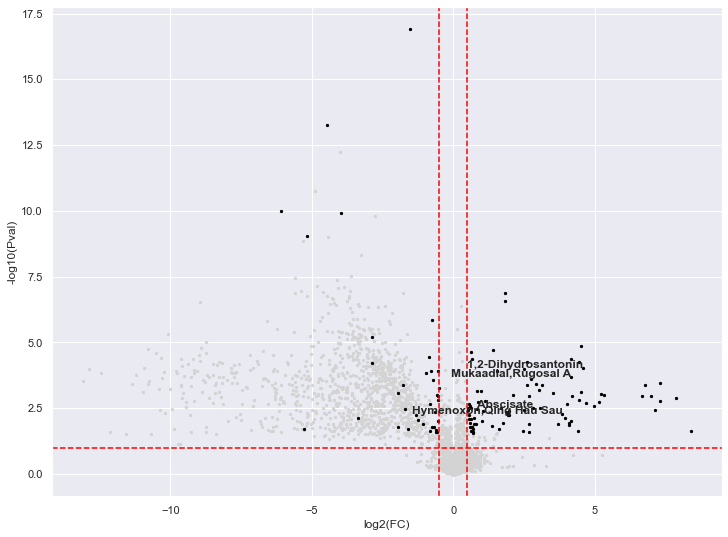

In [447]:
plt.figure(figsize=(12,9))

plt.scatter(np.log2(all_FCs_for_drug), -np.log10(Pvals_exDrug), s = 5, color = 'lightgray')
plt.scatter(np.log2(FC_vals_exDrug), -np.log10(Pvals_exDrug), s = 5, color = 'black')

plt.axvline(x=0.5, linestyle='--', color='red')
plt.axvline(x=-0.5, linestyle='--', color='red')

plt.axhline(y=1, linestyle='--', color='red')



#for x,y,p,l in zip(np.log2(FC_vals_exDrug), -np.log10(Pvals_exDrug), filtered_FC_table_noNA['path_ids'],
#                 filtered_FC_table_noNA['comp_names']):
#    if all([pd.notnull(x), pd.notnull(y), pd.notnull(p), pd.notnull(l)]):
#        if not('map00960' in p):
#            plt.text(x,y,l.split(';')[0], horizontalalignment='right')
        
        
compound_list = []
l_check = []
for x,y,p,l in zip(np.log2(FC_vals_exDrug), -np.log10(Pvals_exDrug), filtered_FC_table_noNA['path_ids'],
                 filtered_FC_table_noNA['comp_names']):
    if all([pd.notnull(x), pd.notnull(y), pd.notnull(p), pd.notnull(l)]):
        if 'map00906' in p:
            if not l in l_check:
                plt.text(x,y,l.split(';')[0], fontweight='bold', horizontalalignment='right')
        l_check.append(l)
        compound_list.append([x,y,l])
        
        

#plt.axhline(y=5, linestyle='--', color='red')


plt.xlabel('log2(FC)')
plt.ylabel('-log10(Pval)')


plt.savefig('intermed_results/21_overview_integration/ARTEMISININ_volcano.svg')

plt.show()


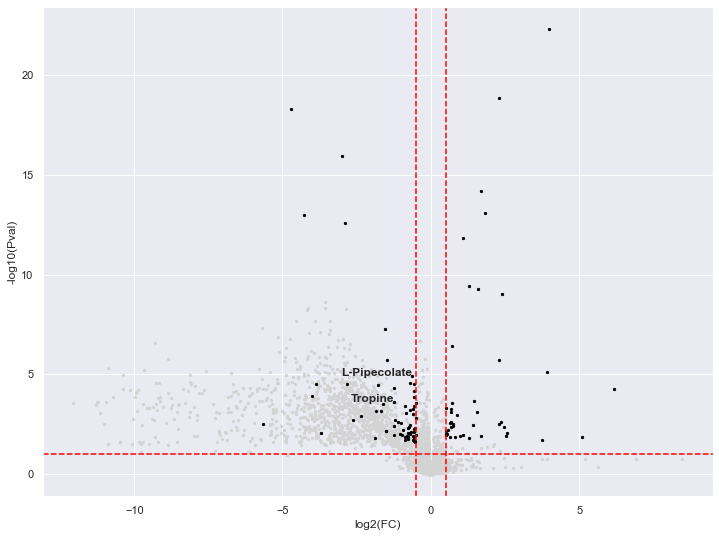

In [455]:
plt.figure(figsize=(12,9))

plt.scatter(np.log2(all_FCs_for_drug), -np.log10(Pvals_exDrug), s = 5, color = 'lightgray')
plt.scatter(np.log2(FC_vals_exDrug), -np.log10(Pvals_exDrug), s = 5, color = 'black')

plt.axvline(x=0.5, linestyle='--', color='red')
plt.axvline(x=-0.5, linestyle='--', color='red')

plt.axhline(y=1, linestyle='--', color='red')



#for x,y,p,l in zip(np.log2(FC_vals_exDrug), -np.log10(Pvals_exDrug), filtered_FC_table_noNA['path_ids'],
#                 filtered_FC_table_noNA['comp_names']):
#    if all([pd.notnull(x), pd.notnull(y), pd.notnull(p), pd.notnull(l)]):
#        if not('map00960' in p):
#            plt.text(x,y,l.split(';')[0], horizontalalignment='right')
        
        
compound_list = []
for x,y,p,l in zip(np.log2(FC_vals_exDrug), -np.log10(Pvals_exDrug), filtered_FC_table_noNA['path_ids'],
                 filtered_FC_table_noNA['comp_names']):
    if all([pd.notnull(x), pd.notnull(y), pd.notnull(p), pd.notnull(l)]):
        if 'map00960' in p:
            if not 'Cocaine' in l:
                plt.text(x,y,l.split(';')[0], fontweight='bold', horizontalalignment='right')
        compound_list.append([x,y,l])
        
        

#plt.axhline(y=5, linestyle='--', color='red')


plt.xlabel('log2(FC)')
plt.ylabel('-log10(Pval)')


plt.savefig('intermed_results/21_overview_integration/PHENYTOIN SODIUM_volcano.svg')

plt.show()


In [434]:
[el[2].split(';')[0] for el in compound_list]

['L-Pipecolate',
 'Tropine',
 '(R)-Mevalonate',
 'Dihydroclavaminic acid',
 'Phenytoin,Oxcarbazepine,Carbamazepine-10,11-epoxide',
 'Cocaine']

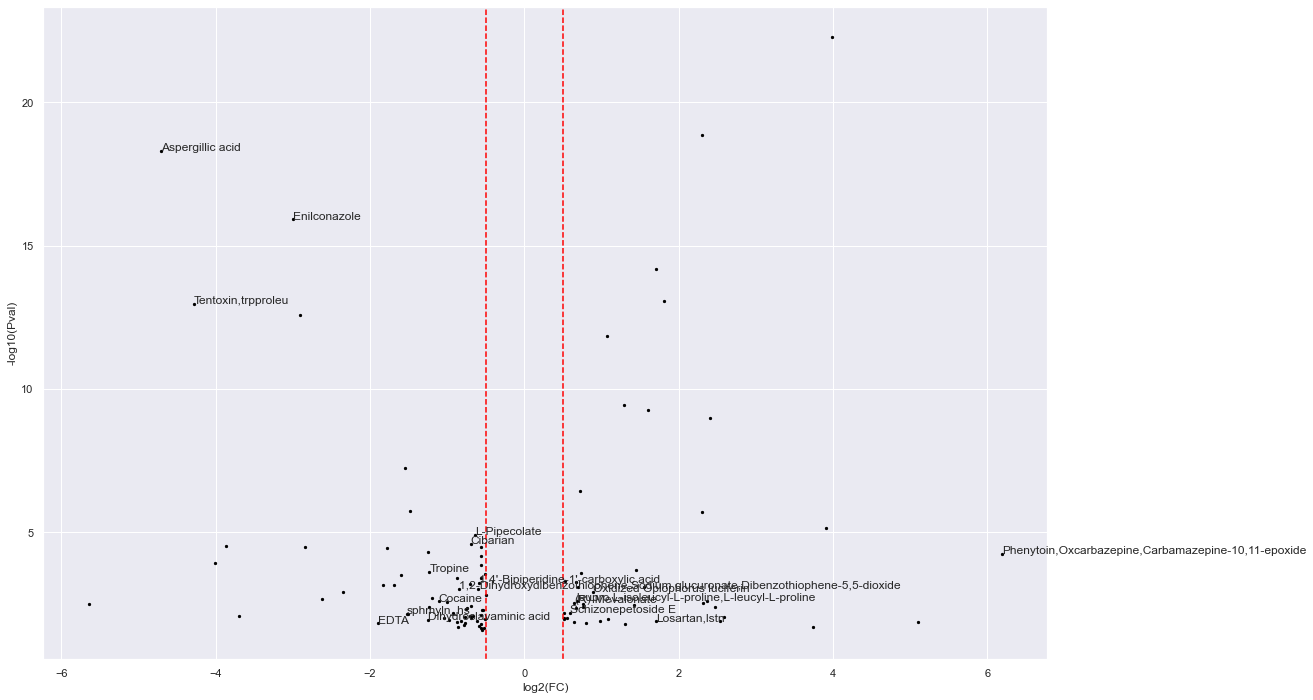

In [196]:
plt.figure(figsize=(18,12))

plt.scatter(np.log2(FC_vals_exDrug), -np.log10(Pvals_exDrug), s = 5, color = 'black')

plt.axvline(x=0.5, linestyle='--', color='red')
plt.axvline(x=-0.5, linestyle='--', color='red')

compound_list = []
for x,y,l in zip(np.log2(FC_vals_exDrug), -np.log10(Pvals_exDrug), filtered_FC_table_noNA['comp_names']):
    if all([pd.notnull(x), pd.notnull(y), pd.notnull(l)]):
        plt.text(x,y,l.split(';')[0])
        compound_list.append([x,y,l])
#plt.axhline(y=5, linestyle='--', color='red')


plt.xlabel('log2(FC)')
plt.ylabel('-log10(Pval)')


plt.show()
